In [36]:
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
%matplotlib inline

In [22]:
input_df = '../dataframes/h3n2_ha_12y_hi.csv'
df_name = str.split(input_df, 'dataframes/')[1]
prefix = str.split(df_name, '.csv')[0]
pre_prefix = str.split(prefix, '_hi')[0]

egg_df = pd.read_csv('../dataframes/h3n2_ha_12y_hi_egg.csv')

In [23]:
adapted_muts = ['G186V','L194P','A138S','H156R','H156Q', 'T203I','S219F','S219Y', 'D225G','N246H']

egg_total = len(egg_df)
egg_passaged = 0
egg_adapted = 0
num_adapted_muts = []
for k, v in egg_df.iterrows():
    
    strain_egg_muts = ast.literal_eval(v['egg_muts'])
    has_adapted_mut = False
    num_egg_adapted = 0
    
    if len(strain_egg_muts) != 0:
        egg_passaged+=1
    
    for adapted_mut in adapted_muts:
        if adapted_mut in strain_egg_muts:
            has_adapted_mut = True
            num_egg_adapted+=1
            
    if has_adapted_mut == True:
        egg_adapted+=1
        num_adapted_muts.append(num_egg_adapted)
    
avg_num_egg_adapted = sum(num_adapted_muts)/len(num_adapted_muts)
print(egg_adapted/egg_total)

0.5526315789473685


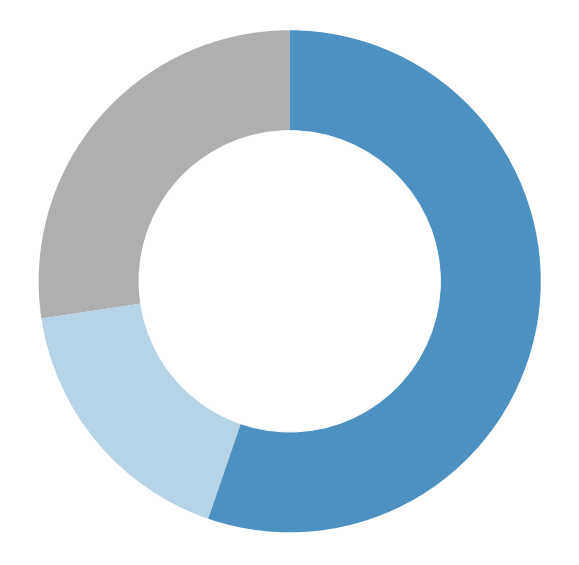

In [68]:
# Pie chart
labels = ['No Mutation', 'Egg-passaged mutation', 'Egg-adapted mutation']
sizes = [(egg_total-egg_passaged), (egg_passaged-egg_adapted), egg_adapted]
#colors
colors = ['#afafaf','#b7d3e6','#4c91c2']

fig, ax = plt.subplots(figsize=(10,10))
# ax.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax.pie(sizes, colors=colors, startangle=90)
ax.axis('equal')  
inner_circle=plt.Circle( (0,0), 0.6, color='white')
fig = plt.gcf()
fig.gca().add_artist(inner_circle)

# plt.savefig("eggadaptation_overall.png", bbox_inches='tight')

In [28]:
muts_to_consider = ['G186V','L194P','A138S','H156R','H156Q', 'T203I','S219F','S219Y', 'D225G','N246H']
titer_diffs = []
for assay in ['hi', 'fra']:
    all_df = pd.read_csv('../dataframes/'+pre_prefix+"_"+assay+'.csv')
    df = all_df[all_df['pair_id']!=0]

    #Re-organize DF to one row per pair
    sub_egg = df[df['passage']=='egg'][['source', 'egg_muts', 'cTiterSub']].rename(columns = {'cTiterSub':'egg_titer'})
    sub_u = df[df['passage']=='unpassaged'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})
    sub_cell = df[df['passage']=='cell'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})

    pairs_u_df = sub_egg.merge(sub_u)
    pairs_cell_df = sub_egg.merge(sub_cell)
    pairs_cell_u_df = sub_u.merge(sub_cell)
    pairs_df = pairs_u_df.merge(pairs_cell_df, how='outer')

    for k,v in pairs_df.iterrows():
        strain_egg_muts = ast.literal_eval(v['egg_muts'])
        has_adapted_mut = False
        diff = v['egg_titer'] - v['pair_titer']
        
        for egg_mut in muts_to_consider:
            if egg_mut in strain_egg_muts:
                has_adapted_mut = True
                
        if has_adapted_mut == True:
            titer_diffs.append({'mutation': 'adapted_mut', 'titer_diff': diff, 'assay': assay})
        elif has_adapted_mut == False:
            titer_diffs.append({'mutation':'no_adapted_mut', 'titer_diff': diff, 'assay': assay})

titer_diffs_df = pd.DataFrame(titer_diffs)



In [31]:
titer_diffs_df.groupby(['mutation', 'assay']).mean()

titer_diff
mutation       assay            
adapted_mut    fra      1.164381
               hi       1.362225
no_adapted_mut fra      0.079681
               hi       0.063417

/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


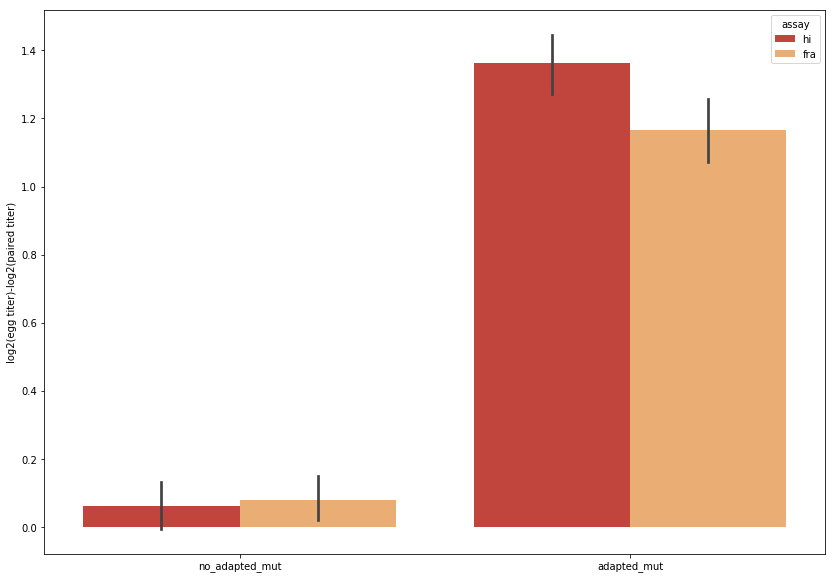

In [65]:
fig, ax = plt.subplots(figsize=(14,10))
fig = sns.barplot(x='mutation', y='titer_diff', hue='assay', data=titer_diffs_df, palette= ['#d73027', '#fdae61'])
ax.set(xlabel = '', ylabel='log2(egg titer)-log2(paired titer)')
plt.savefig("eggadaptation_antigenicity.png", bbox_inches='tight')

In [39]:
titer_stats = []
true_mu = 0

for assay in ['hi', 'fra']:
    for mutation in ['no_adapted_mut', 'adapted_mut']:
        cat1 = titer_diffs_df[(titer_diffs_df['assay']==assay)&(titer_diffs_df['mutation']==mutation)]
        pvalue = ttest_1samp(cat1['titer_diff'], true_mu).pvalue
        titer_stats.append({'assay': assay, 'egg_adapted': mutation,'pvalue': pvalue})
titer_stats_df = pd.DataFrame(titer_stats)
titer_stats_df

,assay,egg_adapted,pvalue
0,hi,no_adapted_mut,7.204997e-02
1,hi,adapted_mut,3.674193e-83
2,fra,no_adapted_mut,1.940883e-02
3,fra,adapted_mut,1.047096e-62
